In [5]:
%matplotlib inline
#import autoreload
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [7]:
import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
from torch.optim.lr_scheduler import OneCycleLR

In [4]:
class Assignment13(LightningModule):
    def __init__(self, lr=0):
        super().__init__()
        self.save_hyperparameters()
        self.epoch_number = 0
        self.config = config
        self.train_csv_path = self.config.DATASET + "/train.csv"
        self.test_csv_path = self.config.DATASET + "/test.csv"
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
              train_csv_path=self.train_csv_path, test_csv_path=self.test_csv_path)
        self.check_class_accuracy = check_class_accuracy
        self.model = YOLOv3(num_classes=self.config.NUM_CLASSES)
        self.loss_fn = YoloLoss()
        self.check_class_accuracy = check_class_accuracy
        self.get_evaluation_bboxes = get_evaluation_bboxes
        self.scaled_anchors = (torch.tensor(self.config.ANCHORS) * torch.tensor(self.config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.losses = []
        self.plot_couple_examples = plot_couple_examples
        self.mean_average_precision = mean_average_precision
    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y0, y1, y2 = (y[0],y[1],y[2])
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0].to(y0))
                + self.loss_fn(out[1], y1, self.scaled_anchors[1].to(y1))
                + self.loss_fn(out[2], y2, self.scaled_anchors[2].to(y2))
            )
        self.losses.append(loss.item())
        mean_loss = sum(self.losses) / len(self.losses)
        self.log("train_loss", mean_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log("train_loss", mean_loss)
        return loss

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def on_train_epoch_start(self):
        self.epoch_number += 1
        self.losses = []
        #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)
      #if self.epoch_number > 1 and self.epoch_number % 3 == 0:
        #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)

    def on_train_epoch_end(self):
        if self.epoch_number == 1:
              #if self.epoch_number > 1 and self.epoch_number % 3 == 0:
            self.check_class_accuracy(self.model, self.test_loader, threshold=self.config.CONF_THRESHOLD)
            pred_boxes, true_boxes = self.get_evaluation_bboxes( self.test_loader,self.model,iou_threshold=self.config.NMS_IOU_THRESH,
                                                                 anchors=self.config.ANCHORS,
                                                                 threshold=self.config.CONF_THRESHOLD,)
            mapval = self.mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=self.config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=self.config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
            pass


    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.config.LEARNING_RATE,
            momentum=0.9,
            weight_decay=self.config.WEIGHT_DECAY)
        EPOCHS = 1
        #EPOCHS = config.NUM_EPOCHS * 2 // 5
        scheduler = OneCycleLR(
                optimizer,
                max_lr=1E-4,
                steps_per_epoch=len(self.train_loader),
                epochs=EPOCHS,
                #pct_start=5/EPOCHS,
                pct_start=0.8,
                div_factor=100,
                three_phase=False,
                final_div_factor=100,
                anneal_strategy='linear'
            )

        return {"optimizer": optimizer, "lr_scheduler":scheduler}
        
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
          return self.train_loader

    def test_dataloader(self):
          return self.test_loader

    

In [5]:
!ls

Assignment13.ipynb     image.png
Exp3.ipynb	       loss.py
PASCAL_VOC	       loss_1_1.py
__pycache__	       main.ipynb
config.py	       main2.ipynb
dataloader.ipynb       model.py
dataset.py	       pascal-voc-dataset-used-in-yolov3-video.zip
dataset_assignment.py  train.py
dataset_org.py	       utils.py


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | YOLOv3   | 62.0 M
1 | loss_fn | YoloLoss | 0     
-------------------------------------
62.0 M    Trainable params
0         Non-trainable params
62.0 M    Total params
123.901   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

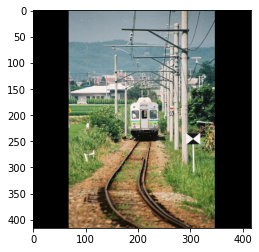

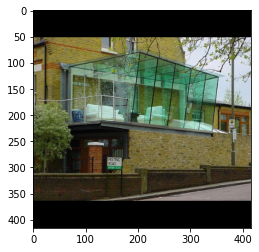

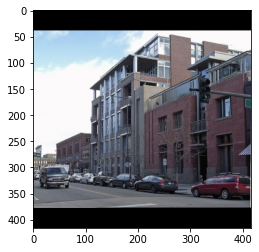

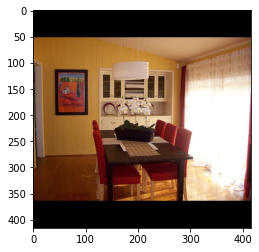

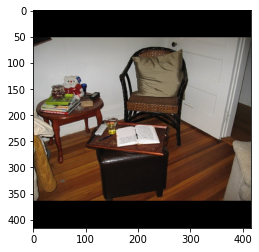

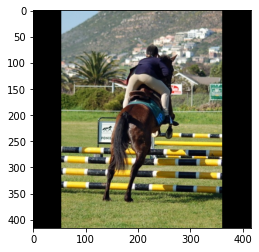

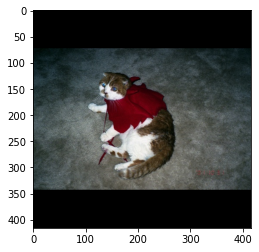

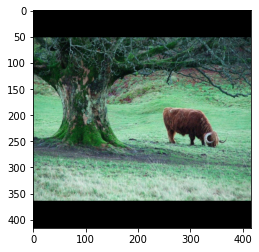


100%|██████████| 155/155 [00:53<00:00,  2.88it/s]


Class accuracy is: 0.551399%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%



  0%|          | 0/155 [00:00<?, ?it/s]

In [ ]:
#running a trail 
model = Assignment13()
trainer = Trainer(precision=16,accelerator='gpu',fast_dev_run=True)
trainer.fit(model)

In [5]:
#finding maximum learning rate
model = Assignment13()
trainer = Trainer(precision=16,accelerator='gpu')

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,max_lr=1, num_training=100,mode="exponential")



Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/yolo_assignment/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 155/155 [01:07<00:00,  2.30it/s]


Class accuracy is: 22.011639%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%


100%|██████████| 155/155 [03:38<00:00,  1.41s/it]
`Trainer.fit` stopped: `max_steps=65` reached.
LR finder stopped early after 65 steps due to diverging loss.
Restoring states from the checkpoint path at /root/yolo_assignment/.lr_find_67643cb3-ae9d-4984-b8cc-127691cf94af.ckpt


MAP: 0.0


Restored all states from the checkpoint file at /root/yolo_assignment/.lr_find_67643cb3-ae9d-4984-b8cc-127691cf94af.ckpt


0.00012022644346174131


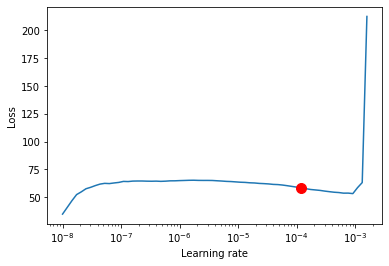

In [6]:
# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)



In [7]:
class Assignment13(LightningModule):
    def __init__(self, lr=0):
        super().__init__()
        self.save_hyperparameters()
        self.epoch_number = 0
        self.config = config
        self.train_csv_path = self.config.DATASET + "/train.csv"
        self.test_csv_path = self.config.DATASET + "/test.csv"
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
              train_csv_path=self.train_csv_path, test_csv_path=self.test_csv_path)
        self.check_class_accuracy = check_class_accuracy
        self.model = YOLOv3()
        self.loss_fn = YoloLoss()
        self.check_class_accuracy = check_class_accuracy
        self.get_evaluation_bboxes = get_evaluation_bboxes
        self.scaled_anchors = (torch.tensor(self.config.ANCHORS) * torch.tensor(self.config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.losses = []
        self.plot_couple_examples = plot_couple_examples
        self.mean_average_precision = mean_average_precision
    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y0, y1, y2 = (y[0],y[1],y[2])
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0].to(y0))
                + self.loss_fn(out[1], y1, self.scaled_anchors[1].to(y1))
                + self.loss_fn(out[2], y2, self.scaled_anchors[2].to(y2))
            )
        self.losses.append(loss.item())
        mean_loss = sum(self.losses) / len(self.losses)
        self.log("train_loss", mean_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log("train_loss", mean_loss)
        return loss

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def on_train_epoch_start(self):
        self.epoch_number += 1
        self.losses = []
        #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)
        print(f"Currently epoch {self.epoch_number}")
        print("On Train Eval loader:")
        print("On Train loader:")
        self.check_class_accuracy(self.model, self.train_loader, threshold=self.config.CONF_THRESHOLD)
        if self.epoch_number > 1 and self.epoch_number % 15 == 0:
            #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)

    def on_train_epoch_end(self):
        if self.epoch_number == 40:
              #if self.epoch_number > 1 and self.epoch_number % 3 == 0:
            self.check_class_accuracy(self.model, self.test_loader, threshold=self.config.CONF_THRESHOLD)
            pred_boxes, true_boxes = self.get_evaluation_bboxes( self.test_loader,self.model,iou_threshold=self.config.NMS_IOU_THRESH,
                                                                 anchors=self.config.ANCHORS,
                                                                 threshold=self.config.CONF_THRESHOLD,)
            mapval = self.mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=self.config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=self.config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
            pass


    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.config.LEARNING_RATE,
            momentum=0.9,
            weight_decay=self.config.WEIGHT_DECAY)
        EPOCHS = 1
        #EPOCHS = config.NUM_EPOCHS * 2 // 5
        scheduler = OneCycleLR(
                optimizer,
                max_lr=5E-5,
                steps_per_epoch=len(self.train_loader),
                epochs=EPOCHS,
                #pct_start=5/EPOCHS,
                pct_start=0.8,
                div_factor=100,
                three_phase=False,
                final_div_factor=100,
                anneal_strategy='linear'
            )

        return {"optimizer": optimizer, "lr_scheduler":scheduler}
        
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
          return self.train_loader

    def test_dataloader(self):
          return self.test_loader

    

In [8]:
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',  # Metric to monitor for saving the best model
    mode='min',          # 'min' to save the model with the lowest value of the monitored metric
    save_top_k=1         # Save only the best model
)

trainer = Trainer(
    max_epochs=2,
    accelerator="gpu",
    precision=16,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10),checkpoint_callback],
)


trainer.fit(model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | YOLOv3   | 62.0 M
1 | loss_fn | YoloLoss | 0     
-------------------------------------
62.0 M    Trainable params
0         Non-trainable params
62.0 M    Total params
123.901   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [9]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

,lr-SGD,train_loss_step,train_loss_epoch
epoch,,,
NaN,0.000001,NaN,NaN
0.0,NaN,64.089584,NaN
NaN,0.000001,NaN,NaN
0.0,NaN,59.663727,NaN
NaN,0.000001,NaN,NaN


NameError: name 'sn' is not defined

In [7]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
EPOCHS = config.NUM_EPOCHS * 2 // 5
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
        
return {"optimizer": optimizer, "lr_scheduler":scheduler}

In [ ]:
EPOCHS = config.NUM_EPOCHS * 2 // 5
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )


0.006918309709189364


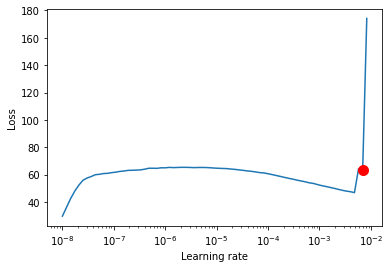

In [6]:
# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
#model.hparams.lr = new_lr

In [ ]:
max_lr: float = 1,
    num_training: int = 100,
    mode: str = "exponential",

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
#model.hparams.lr = new_lr

In [ ]:
#rough 
def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
#scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Trainer(precision=16) callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10),checkpoint_callback],
)

In [ ]:
train_loader, test_loader, train_eval_loader = get_loaders(
    train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/test.csv"
)